In [87]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib
import mpl_toolkits.mplot3d

from scipy.optimize import fsolve
import scipy.sparse.linalg as spla

import numpy as np
import numpy.linalg as la

import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [2]:
matplotlib.rcParams.update({'font.size': 16})

In [3]:
def torus_phyllotaxis_points(N):
    R, r = 1, 1/3
    gr = (1 + np.sqrt(5))/2
    gamma = 2*np.pi*(1- 1/gr)
    pmax = 2*np.pi
    caparea = lambda x: 2*np.pi*(3*x + np.sin(x))/9
    c = N/caparea(pmax)
    t = np.arange(1,N+1)*gamma
    p = np.zeros(N)
    p[0] = fsolve(lambda x: caparea(x)-1/c, 0)
    for i in range(1,N):
        p[i] = fsolve(lambda x: caparea(x)-i/c, p[i-1])
    nodes = np.zeros((N, 3))
    nodes[:, 0] = (R + r*np.cos(p)) * np.cos(t)
    nodes[:, 1] = (R + r*np.cos(p)) * np.sin(t)
    nodes[:, 2] = r*np.sin(p)

    normals = np.zeros((N,3))
    normals[:, 0] = r*np.cos(p)*np.cos(t)*(R+r*np.cos(p))
    normals[:, 1] = r*np.cos(p)*np.sin(t)*(R+r*np.cos(p))
    normals[:, 2] = r*np.sin(p) * (R + r*np.cos(p)) * np.cos(t)**2 + r*np.sin(p) * (R+r*np.cos(p))*np.sin(t)**2
    
    lengths = np.sqrt(normals[:,0]**2 + normals[:,1]**2 + normals[:,2]**2)
    
    normals[:,0] /= lengths
    normals[:,1] /= lengths
    normals[:,2] /= lengths
    
    return nodes, normals

In [4]:
def get_parameters(x, R, r):
    theta = np.arctan2(x[:,1], x[:,0])
    phi = np.arctan2(x[:,2], np.sqrt(x[:,0]**2 + x[:,1]**2) - R)
    return theta, phi

def torus_to_cart(theta, phi, R, r):
    nodes = np.zeros((len(phi), 3))
    nodes[:,0] = (R + r*np.cos(phi))*np.cos(theta)
    nodes[:,1] = (R + r*np.cos(phi))*np.sin(theta)
    nodes[:,2] = r*np.sin(phi)
    return nodes

In [99]:
def torus_forcing(nodes):
#     a, b = np.sqrt(4), np.sqrt(20)
    a, b = 2, 2*3
    
    # create gaussian centers
    theta_cs = np.array([0, .5,   1,    2, 4, 5, 3.141])
    phi_cs   = np.array([0,  4, 1.5, -1.5, 0, 4, 3.141/2])
    shapes = [1, .5, 2, .1, .7, .9, .3]
    
    thetas, phis = get_parameters(nodes, 1, 1/3)
    
    N, K = len(nodes), len(theta_cs)
    
    us = np.zeros(N)
    lap = np.zeros(N)
    
    ct, st = np.cos(thetas), np.sin(thetas)
    cp, sp = np.cos(phis), np.sin(phis)
    for k in range(K):
        s = shapes[k]
        spk = np.sin(phis - phi_cs[k])
        cpk = np.cos(phis - phi_cs[k])
        stk = np.sin(thetas - theta_cs[k])
        ctk = np.cos(thetas - theta_cs[k])
        
        uk = np.exp(-s* (a**2*(1-cpk) + b**2*(1-ctk))  )
        C = 1*a**4*s**2*spk**2*cp*ct + 3*a**4*s**2*spk**2*cp + \
            3*a**4*s**2*spk**2*ct + 9*a**4*s**2*spk**2 - 1*a**2*s*cp*ct*cpk \
            - 3*a**2*s*cp*cpk - 3*a**2*s*ct*cpk - 9*a**2*s*cpk \
            + b**4*s**2*stk**2 - b**2*s*ctk
        C /= (1+cp/3)**2
        lap += C*uk
        us += uk
    return us, lap

<IPython.core.display.Javascript object>


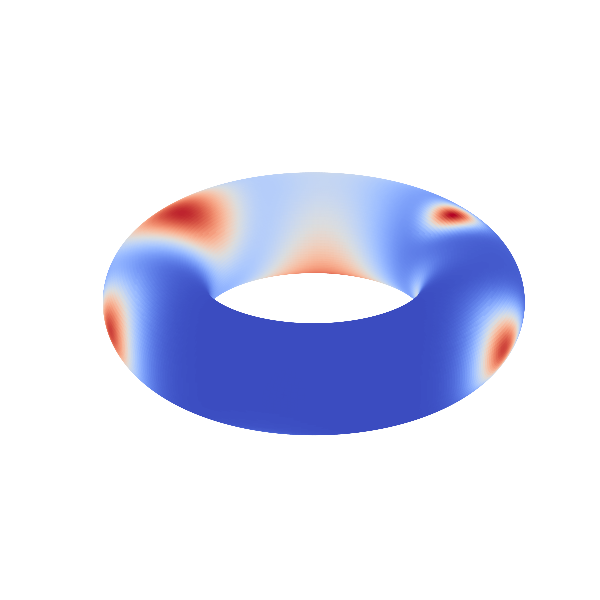

In [90]:
n_t, n_p = 400, 100

thetas = np.linspace(0, 2*np.pi, n_t)
phis = np.linspace(0, 2*np.pi, n_p)

U = np.outer(np.ones(n_p), thetas).flatten()
V = np.outer(phis, np.ones(n_t)).flatten()

nodes = torus_to_cart(U, V, 1, 1/3)

X = nodes[:, 0].reshape((n_p,n_t))
Y = nodes[:, 1].reshape((n_p,n_t))
Z = nodes[:, 2].reshape((n_p,n_t))

us, fs = torus_forcing(nodes)

val = us.reshape((n_p,n_t))

# fourth dimention - colormap
# create colormap according to x-value (can use any 50x50 array)
color_dimension = val # change to desired fourth dimension
minn, maxx = color_dimension.min(), color_dimension.max()
norm = matplotlib.colors.Normalize(minn, maxx)
m = plt.cm.ScalarMappable(norm=norm, cmap='coolwarm')
m.set_array([])
fcolors = m.to_rgba(color_dimension)

# plot

fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
line = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, facecolors=fcolors, vmin=minn, vmax=maxx, shade=False)

axlim = .8
ax.set_xlim(-axlim,axlim)
ax.set_ylim(-axlim,axlim)
ax.set_zlim(-axlim,axlim)

plt.axis('off')
ax.grid(False)

<IPython.core.display.Javascript object>


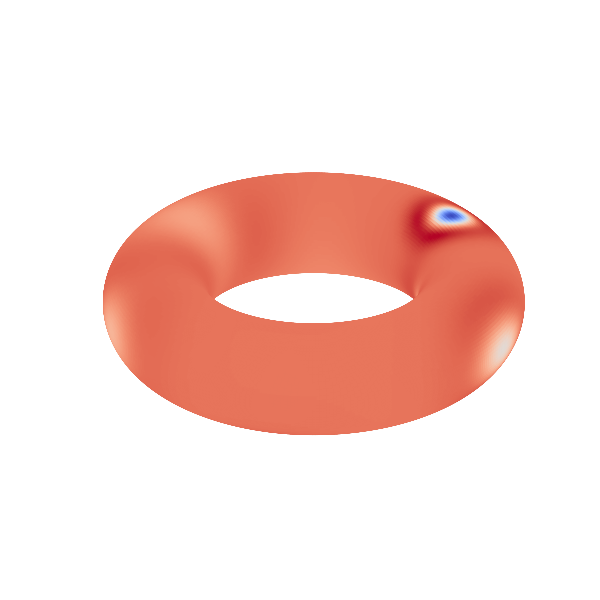

In [94]:
val = fs.reshape((n_p,n_t))
# fourth dimention - colormap
# create colormap according to x-value (can use any 50x50 array)
color_dimension = val # change to desired fourth dimension
minn, maxx = color_dimension.min(), color_dimension.max()
norm = matplotlib.colors.Normalize(minn, maxx)
m = plt.cm.ScalarMappable(norm=norm, cmap='coolwarm')
m.set_array([])
fcolors = m.to_rgba(color_dimension)

# plot

fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
line = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, facecolors=fcolors, vmin=minn, vmax=maxx, shade=False)

axlim = .8
ax.set_xlim(-axlim,axlim)
ax.set_ylim(-axlim,axlim)
ax.set_zlim(-axlim,axlim)

plt.axis('off')
ax.grid(False)

In [26]:
np.max(fs)

328.18546813866493

# Diffusion testing

In [95]:
from laplacebeltrami import *
from rbf import *

In [100]:
n = 1000
nodes, normals = torus_phyllotaxis_points(n)
us, fs = torus_forcing2(nodes)

In [115]:
C = TPM(nodes, normals, rbf_obj=rbf_dict['r^9'], epsilon=None, stencil_size=11, poly_deg=2)
# C = SWM(nodes, normals, rbf_obj=rbf_dict['multiquadric'], epsilon=None, stencil_size=51, poly_deg=4)
# C = SOGr(nodes, normals, rbf_obj=rbf_dict['multiquadric'], stencil_size=200, poly_deg=4)

In [116]:
print(la.norm(C @ us - fs)/la.norm(fs))

0.08324787763457071


In [53]:
eigs = spla.eigs(C, k=min(n,50), which='LR')[0]
# eigs = la.eig(C.todense())[0]
print( np.max(eigs.real), np.max(np.abs(eigs.imag)) )

4.3011195529412433e-14 0.0


<IPython.core.display.Javascript object>


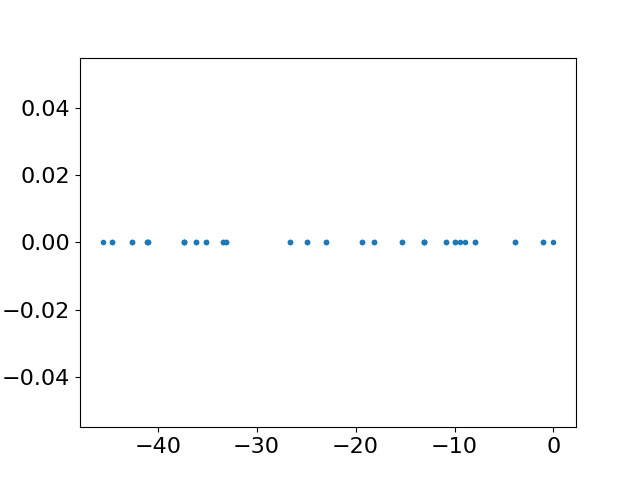

In [54]:
fig = plt.figure()
plt.plot(eigs.real, eigs.imag, '.')
plt.show()

<IPython.core.display.Javascript object>


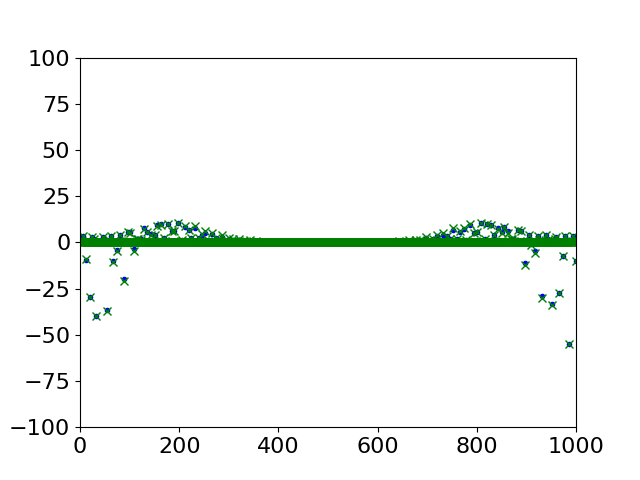

In [106]:
fig = plt.figure()
plt.plot(range(len(us)), C@us, 'b.')
plt.plot(range(len(us)), fs, 'gx')
plt.xlim(0,len(us))
plt.ylim(-100, 100)
plt.show()

In [73]:
def rbf_interp(xs, fs, zs, rbf_obj, k=25, eps=None):
    rbf = rbf_obj['rbf']
    us = np.zeros(len(zs))
    full_dist_mat = dist_outer(xs, zs)
    closest_ids = np.argmin(full_dist_mat, axis=1)
    # in a zoop build surface around each sample point
    for i in range(len(xs)):
        c = xs[i]
        close_to_c_ids = closest_ids == i
        zs_local = zs[close_to_c_ids]
        x_ids = get_closest_indices(i, len(xs), k)
        xs_local = xs[x_ids]
        fs_local = fs[x_ids]
        dist_mat = dist_outer(xs_local,xs_local)
        if rbf_obj['shape'] and eps is None:   
            eps = optimize_eps(rbf, dist_mat)
        A = rbf(dist_mat, eps)
        cs = la.solve(A, fs_local)
        dist_mat = dist_outer(xs_local, zs_local)
        A = rbf(dist_mat, eps)
        us_local = A @ cs
        us[close_to_c_ids] = us_local
    return us

<IPython.core.display.Javascript object>


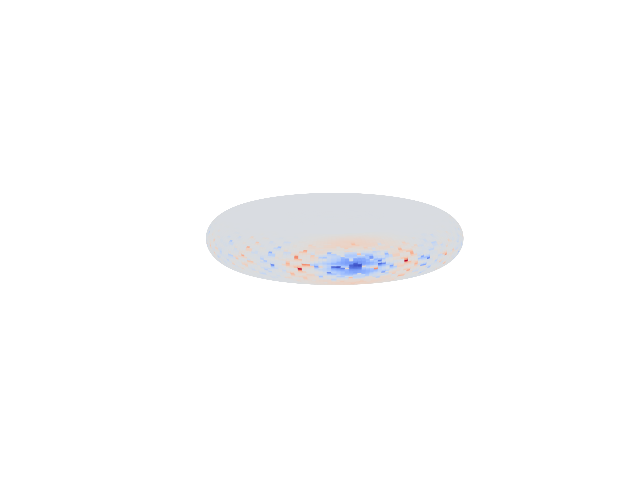

In [74]:
n1, n2 = 200, 100

thetas = np.linspace(0, 2*np.pi, n1)
phis = np.linspace(0, 2*np.pi, n2)

U = np.outer(np.ones(n2), thetas).flatten()
V = np.outer(phis, np.ones(n1)).flatten()

plot_nodes = torus_to_cart(U, V, 1, 1/3)

X = plot_nodes[:, 0].reshape((n2,n1))
Y = plot_nodes[:, 1].reshape((n2,n1))
Z = plot_nodes[:, 2].reshape((n2,n1))

fs_approx = rbf_interp(nodes, C@us, plot_nodes, rbf_dict['multiquadric'], k=50)

val = fs_approx.reshape((n2,n1))

# fourth dimention - colormap
# create colormap according to x-value (can use any 50x50 array)
color_dimension = val # change to desired fourth dimension
minn, maxx = color_dimension.min(), color_dimension.max()
norm = matplotlib.colors.Normalize(minn, maxx)
m = plt.cm.ScalarMappable(norm=norm, cmap='coolwarm')
m.set_array([])
fcolors = m.to_rgba(color_dimension)

# plot

fig = plt.figure()
ax = fig.gca(projection='3d')
line = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, facecolors=fcolors, vmin=minn, vmax=maxx, shade=False)

ax.set_xlim(-1.4,1.4)
ax.set_ylim(-1.4,1.4)
ax.set_zlim(-1.4,1.4)

plt.axis('off')
ax.grid(False)

In [402]:
n = 20000
nodes, normals = torus_phyllotaxis_points(n)
us, fs = torus_forcing(nodes)
tree = cKDTree(np.array(nodes))

In [423]:
my_index = 0
k = 51
rbf_obj=rbf_dict['multiquadric']
poly_deg = 0
epsilon = None




n = len(nodes)
rbf = rbf_obj['rbf']
phi1  = rbf_obj['phi1']
d2rbf = rbf_obj['d2rbf']
Lrbf = lambda r,epsilon: phi1(r,epsilon) + d2rbf(r,epsilon)

e1, e2, e3 = np.eye(3)
E = np.eye(3)
E[2,2] = 0

node, normal = nodes[my_index], normals[my_index]

t1 = e2 - np.dot(normal, e2)*normal
t1 /= la.norm(t1)
t2 = e3 - np.dot(normal, e3)*normal - np.dot(t1, e3)*t1
t2 /= la.norm(t2)

R = np.zeros((3,3))
R[:,0] = t1
R[:,1] = t2

stencil = tree.query(node, k)[1]

my_nn = np.array([nodes[i] for i in stencil])
my_us = np.array([us[i] for i in stencil])

nn = (my_nn-my_nn[0]) @ R
scale = np.max(np.abs(nn))
nn /= scale

dist_mat = dist_outer(nn, nn)
if not poly_deg is None:
    terms = (poly_deg+1)*(poly_deg+2)//2
    P = np.ones((k, terms))
    x = nn[:,0]
    y = nn[:,1]
    p1, p2 = 0, 1
    for d in range(1,poly_deg+1):
        for j in range(d):
            P[:,p2+j] = P[:,p1+j]*x
        P[:,p2+d] = P[:,p1+j]*y
        p1, p2 = p2, p2+d+1
    if epsilon is None and rbf_obj['shape']:
        epsilon = optimize_eps(rbf, dist_mat, P=P, target_cond=10**12)
        print('epsilon = %g' % epsilon)
    A = rbf(dist_mat, epsilon)
    A = np.block([[A, P],[P.T, np.zeros((terms, terms))]])
    rhs = np.zeros(k+terms)
    rhs[:k] = Lrbf(dist_mat[0], epsilon)
    if poly_deg >=2:
        rhs[k+3] = 2
        rhs[k+5] = 2
    rhs /= scale**2
    weights = la.solve(A, rhs.flatten())[:k]
else:
    if epsilon is None and rbf_obj['shape']:
        epsilon = optimize_eps(rbf, dist_mat, P=None, target_cond=10**12)
        print('epsilon = %g' % epsilon)
    A = rbf(dist_mat, epsilon)
    rhs = Lrbf(dist_mat[0], epsilon) / scale**2
    weights = la.solve(A, rhs.flatten())



epsilon = 0.512694


In [424]:
print(weights @ my_us)
print(fs[my_index])

0.3307277391572573
-2.182620000782636


In [425]:
np.log10(cond(A))

11.999999831913717

<IPython.core.display.Javascript object>


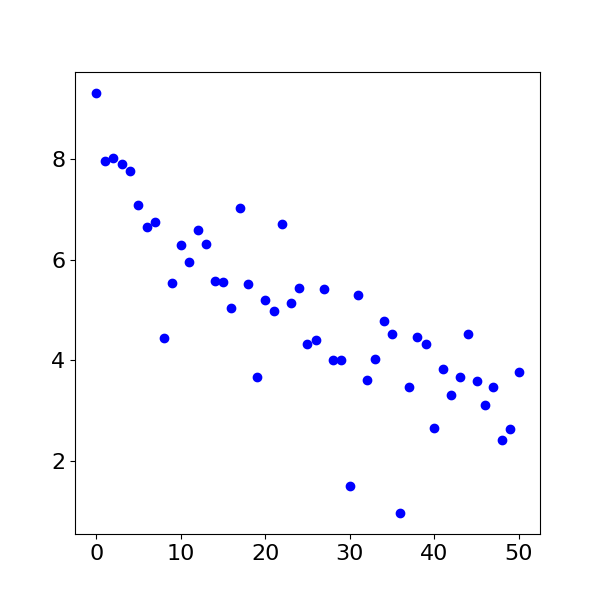

In [420]:
fig = plt.figure(figsize=(6,6))

plt.plot(range(len(weights)), np.log(np.abs(weights)), 'bo')

plt.show()

<IPython.core.display.Javascript object>


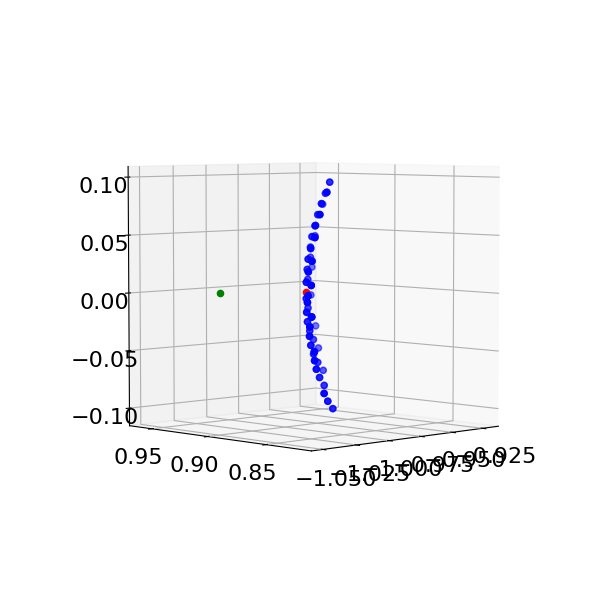

In [407]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

r = .05
ax.scatter(node[0], node[1], node[2], '.', color='r')
ax.scatter(node[0]+r*normal[0], node[1]+r*normal[1], node[2]+r*normal[2], '.', color='g')
ax.scatter(my_nn[1:,0], my_nn[1:,1], my_nn[1:,2], '.', color='b')
ax.scatter(my_nn[1:,0], my_nn[1:,1], my_nn[1:,2], '.', color='b')
# ax.scatter(normal[0], normal[1], normal[2], '.', color='g')
# ax.scatter(0, 0, 0, '.', color='k')

# ax.set_xlim(-1.4,1.4)
# ax.set_ylim(-1.4,1.4)
# ax.set_zlim(-1.4,1.4)
plt.show()

<IPython.core.display.Javascript object>


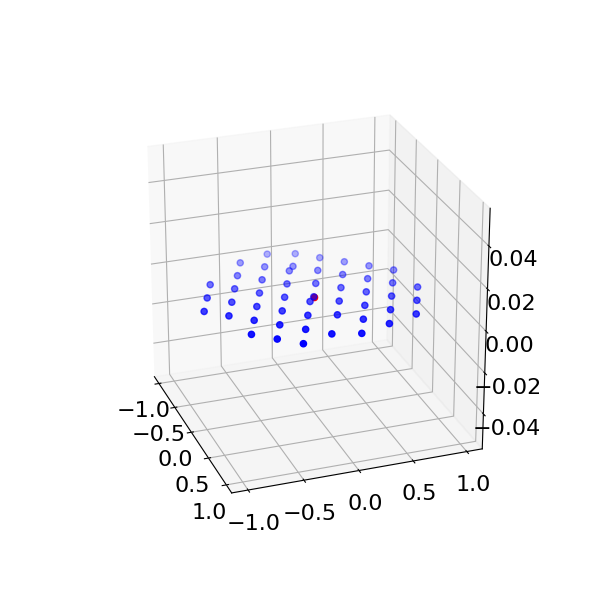

In [413]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

r = .3
# ax.scatter(nn[:,0], nn[:,1], [0]*len(nn[:,0]), '.', color='b')
ax.scatter(nn[:,0], nn[:,1], nn[:,2], '.', color='b')
# ax.scatter(nn[0,0], nn[0,1], 0, '.', color='g')
ax.scatter(0, 0, 0, '.', color='r')

ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)
# ax.set_zlim(-1.4,1.4)
plt.show()

Surface laplacian of torus is given here: https://arxiv.org/pdf/1404.0812.pdf

In [67]:
from sympy import *

In [68]:
a, b, p, t, p0, t0, s = symbols('a b p t p0 t0 s')

In [69]:
u = exp(-s*(a**2*(1-cos(p-p0)) + b**2*(1-cos(t-t0))))
d = (1+1/3*cos(p))

In [70]:
expr = diff(u, t, t) + 9*d*(diff(  (1+1/3*cos(t))*diff(u,p), p)  )
expr = (expr/u).simplify().expand()

In [71]:
display(expr)

1.0*a**4*s**2*sin(p - p0)**2*cos(p)*cos(t) + 3.0*a**4*s**2*sin(p - p0)**2*cos(p) + 3.0*a**4*s**2*sin(p - p0)**2*cos(t) + 9*a**4*s**2*sin(p - p0)**2 - 1.0*a**2*s*cos(p)*cos(t)*cos(p - p0) - 3.0*a**2*s*cos(p)*cos(p - p0) - 3.0*a**2*s*cos(t)*cos(p - p0) - 9*a**2*s*cos(p - p0) + b**4*s**2*sin(t - t0)**2 - b**2*s*cos(t - t0)

In [72]:
s = str(expr)
s = s.replace('.0', '')
s = s.replace('sin(p - p0)', 'spk')
s = s.replace('cos(p - p0)', 'cpk')
s = s.replace('sin(t - t0)', 'stk')
s = s.replace('cos(t - t0)', 'ctk')
s = s.replace('cos(p)', 'cp')
s = s.replace('cos(t)', 'ct')

In [73]:
s

'1*a**4*s**2*spk**2*cp*ct + 3*a**4*s**2*spk**2*cp + 3*a**4*s**2*spk**2*ct + 9*a**4*s**2*spk**2 - 1*a**2*s*cp*ct*cpk - 3*a**2*s*cp*cpk - 3*a**2*s*ct*cpk - 9*a**2*s*cpk + b**4*s**2*stk**2 - b**2*s*ctk'